<center><span style="font-size:40px;"><b>GPU ACCELERATION</b></span></center>

In [1]:
from IPython.display import Image, display

---

# 00 - INTRODUCTION

Modern scientific computing often involves processing large amounts of data or performing intensive numerical calculations. **Graphics Processing Units (GPUs)** have become an essential tool in this context, offering a highly parallel architecture that can dramatically accelerate many computational tasks compared to traditional **Central Processing Units (CPUs)**.

Originally designed for rendering graphics, GPUs are built to perform thousands of simple operations simultaneously. This makes them ideal for workloads where the same computation must be repeated many times over large datasets — a common scenario in physics simulations, data analysis, and machine learning.

A GPU consists of hundreds or thousands of smaller cores capable of executing threads in parallel, while a CPU typically has only a few powerful cores optimized for sequential processing and complex control logic. This fundamental architectural difference explains why **GPUs excel at data-parallel problems**, where the same operation is applied independently to many elements.

Frameworks such as **CUDA** (for NVIDIA GPUs) or **OpenCL** allow developers to write code that explicitly leverages GPU hardware. Many high-level libraries (e.g., PyTorch, TensorFlow, CuPy) integrate GPU acceleration transparently, enabling scientists and engineers to benefit from massive parallelism without managing low-level details.

### THREADS VS PROCESSES

A **process is an independent instance of a program with its own memory space, variables, and system resources**. Each process operates in isolation from others — this ensures stability and security, as one process cannot directly modify the memory of another. Communication between processes (known as inter-process communication, or IPC) is possible but relatively slow, since data must be copied between separate memory spaces.

A **thread is a lightweight unit of execution within a process**. Multiple threads belonging to the same process share the same memory space and resources but have their own program counter, registers, and stack. Because they share memory, threads can communicate quickly, but this also introduces challenges such as race conditions and the need for synchronization mechanisms.

The GPU programming model is conceptually similar to multithreading, but at a much larger scale. When a kernel (a function executed on the GPU) is launched, it creates thousands or even millions of lightweight threads. These threads:
- Execute in parallel using the SIMT (Single Instruction, Multiple Threads) model.
- Are grouped into blocks, which are scheduled on the GPU’s Streaming Multiprocessors (SMs).
- Can cooperate via shared memory within a block, similar to how CPU threads share memory within a process.

In this sense, a GPU kernel launch can be seen as creating a vast number of threads that work together to solve a problem in parallel. 

#### EXAMPLE
Consider a program that needs to process 1000 images:
- Using multiple processes, the program might start 4 independent processes, each handling 250 images. Each process would have its own copy of the data and code.
- Using multiple threads, the program could launch 4 threads within a single process, all sharing the same dataset but working on different portions of it simultaneously.


### CUDA VS PYTORCH/TENSORFLOW

CUDA (Compute Unified Device Architecture) is a parallel computing platform and programming model developed by NVIDIA that allows developers to leverage the full power of NVIDIA GPUs. With CUDA, programmers can write functions called **kernels** that run directly on the GPU, giving fine-grained control over parallel execution, memory management, and optimization.

CUDA provides a programming model based on C, C++, and Fortran, with extensions for parallelism.

While CUDA allows maximum flexibility and performance, it also requires **low-level programming**, careful management of memory, thread organization, and synchronization. This can be time-consuming and error-prone, especially for complex applications.

High-level libraries such as PyTorch or TensorFlow build on top of CUDA and provide:
- Pre-implemented GPU-accelerated operations (e.g., matrix multiplication, convolution, reductions).
- Automatic handling of memory transfers between CPU and GPU.
- Simplified APIs that allow scientists and engineers to focus on algorithm design rather than GPU hardware details.


| Feature | CUDA | High-Level Libraries (PyTorch/TensorFlow) |
|---------|------|-----------------------------------------|
| Control | Full, low-level control over threads and memory | Abstracted, user-friendly interface |
| Flexibility | Can implement any GPU algorithm | Limited to provided operations or custom kernels |
| Performance | Maximum possible if optimized correctly | Slightly lower, but often sufficient for most applications |
| Ease of Use | Complex, requires GPU programming knowledge | Easy, Python-friendly, minimal GPU expertise needed |

In summary, CUDA is the foundation that gives direct access to GPU hardware, while libraries like PyTorch or TensorFlow provide convenient, high-level abstractions for GPU acceleration. Researchers often start with these libraries for rapid development and switch to CUDA only when custom optimization is necessary.

### MEMORY TYPES IN MODERN COMPUTING

Memory in computers and GPUs exists in several forms, each with different speed, size, and purpose. Understanding these differences is crucial for optimizing performance in scientific computing.

#### CPU MEMORY (CACHE)
Cache is a small, extremely fast memory located very close to the CPU cores. It stores frequently used data to reduce the time needed to access main memory. Modern CPUs typically have three levels of cache:
- L1 Cache: Smallest (tens of KB), fastest, located inside each CPU core.
- L2 Cache: Medium (hundreds of KB), slightly slower, may be shared between cores.
- L3 Cache: Largest (MBs), slower than L1/L2, shared among all cores.

Caches are usually made of SRAM (Static RAM): fast, expensive, volatile memory. Data is stored using flip-flop circuits and does not need to be refreshed.

#### RAM
RAM (Random Access Memory) is the main memory used by CPUs to store programs and data. It is larger (like tens of GB) but slower than CPU cache and located farther from the CPU cores. 

Most system RAM is DRAM (Dynamic RAM): cheaper and denser than SRAM, but slower. Stores data in capacitors that must be periodically refreshed to retain information. Example: DDR4, DDR5 memory modules in PCs.

#### GPU MEMORY (VRAM)
VRAM (Video RAM) is the memory dedicated to GPUs, used to store data that will be processed by CUDA cores or rendered to the screen. Modern GPUs use high-bandwidth memory technologies, such as:
- GDDR6 (Graphics Double Data Rate 6):
  - Successor to GDDR5, optimized for graphics and data-parallel workloads.
  - High bandwidth (hundreds of GB/s), relatively low latency.
- HBM2 / HBM3 (High Bandwidth Memory):
  - Stacked memory placed very close to GPU cores.
  - Extremely high bandwidth (hundreds of GB/s) with lower power consumption.

VRAM is crucial because GPU performance is often limited by memory bandwidth. Fast VRAM allows the GPU to feed thousands of cores simultaneously.

---

---

---

---

# 01 - CPU AND GPU ARCHITECTURES

### CPU FEATURES

The Central Processing Unit (CPU) is the general-purpose core of a computer system. It is designed to handle a wide variety of tasks efficiently, focusing on sequential execution and complex control flows rather than massive parallelism. A typical CPU contains a few powerful cores (usually between 4 and 32), each capable of executing multiple threads through techniques such as hyper-threading or simultaneous multithreading (SMT).

Each CPU core includes several important architectural elements:
- Arithmetic Logic Unit (ALU) for performing arithmetic and logical operations.
- Control Unit (CU) to manage the execution of instructions.
- Registers for storing temporary data very close to the execution units.
- Cache memory layers (L1, L2, and sometimes L3) that bridge the speed gap between the CPU and the main memory (RAM).

These cache layers play a crucial role in performance (but they are really expensive):
- L1 cache is the fastest and smallest, located directly on each core, providing access times of just a few CPU cycles.
- L2 cache is larger but slightly slower, shared by fewer cores or dedicated per core depending on the architecture.
- L3 cache is even larger and slower, often shared among all cores.
- Accessing main memory (RAM) is much slower — often hundreds of cycles compared to a few for cache — creating a bottleneck when data cannot be found in cache (a cache miss).

Because the CPU runs at very high clock frequencies (often several GHz), its performance heavily depends on efficient memory access patterns and minimizing cache misses. **This makes CPUs ideal for sequential, control-heavy, or latency-sensitive tasks**, where each instruction may depend on the result of the previous one. So things like decision-making, running an OS, sequential algorithms, code with branching (if/else).

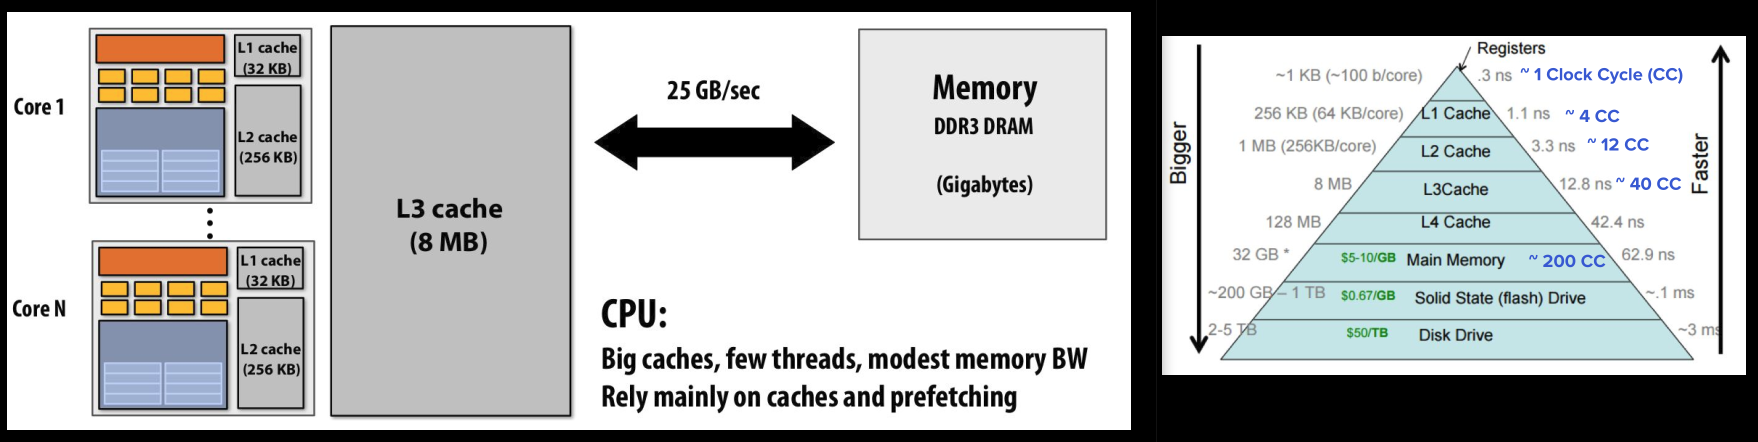

In [5]:
display(Image("./images/MCP_cpu_arch.png", width=1100))

### GPU FEATURES

A Graphics Processing Unit (GPU) is designed to perform a massive number of simple, independent computations in parallel. Unlike the CPU, which focuses on low-latency and complex control flows, the **GPU architecture is optimized for high throughput** — that is, executing many threads simultaneously to process large datasets efficiently.

A modern GPU is composed of several **Streaming Multiprocessors (SMs or SMPs)**, each containing hundreds of lightweight processing cores. Every SM executes groups of threads called **warps** (typically 32 threads), which perform the same instruction simultaneously on different data. This execution model is known as SIMT (Single Instruction, Multiple Threads). When threads within a warp diverge (i.e., follow different execution paths), performance can drop because divergent instructions are serialized.

The GPU architecture also includes:
- Registers for each thread, providing the fastest access to data.
- Shared memory within each SM, allowing threads in the same block to communicate and share intermediate results efficiently.
- Global memory, which is accessible to all threads but much slower than shared memory.
- Additional specialized memories, such as constant and texture memory, optimized for specific access patterns.

The GPU memory hierarchy is designed differently from the CPU’s cache system. While the CPU relies heavily on multiple cache layers (L1, L2, L3) to minimize latency, the GPU’s focus is on hiding latency by scheduling other warps while some are waiting for memory operations to complete. This massive parallel scheduling ensures that computational units remain busy as often as possible.

GPUs achieve their impressive performance by combining:
- Thousands of simple cores executing in parallel.
- A lightweight thread scheduling mechanism.
- High memory bandwidth optimized for streaming data rather than random access.

This makes GPUs extremely effective for **data-parallel** workloads, such as linear algebra, image and signal processing, physical simulations, and deep learning training.


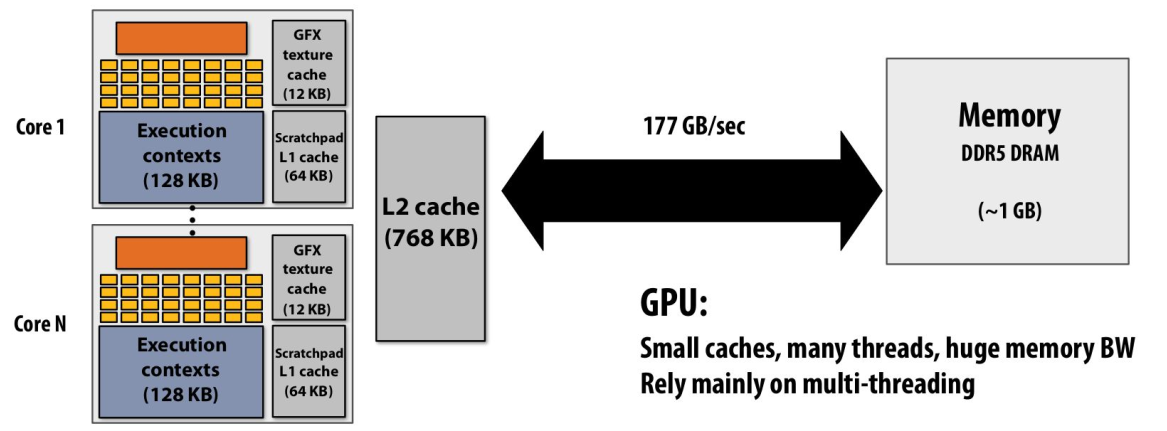

In [7]:
display(Image("./images/MCP_gpu_arch.png", width=800))

### GPU ARCHITECTURE

**The GPU architecture is organized in a three-level hierarchy**, designed to maximize parallelism while efficiently managing thousands of lightweight threads.

#### 1. CUDA CORES (STREAMING PROCESSORS, SPs)
At the lowest level, the fundamental unit of computation is the **CUDA Core**, also known as a **Streaming Processor (SP)**.  
Each CUDA Core:
- Is typically a scalar processor (SISD: Single Instruction, Single Data), meaning it executes one operation per clock cycle.
- Lacks complex CPU features such as out-of-order execution or branch prediction, which simplifies the hardware and allows for more cores on a single chip.
- Contains ALUs capable of performing arithmetic on different data types — integers, 16-bit (Float16), 32-bit (Float32), or 64-bit (Float64) floating-point numbers — depending on the architecture.
- Can be fully pipelined, allowing new operations to start every cycle for continuous execution.

In more modern GPUs, individual CUDA cores may also support vector (SIMD) instructions, increasing efficiency for operations on multiple data elements simultaneously.

#### 2. STREAMING MULTIPROCESSORS (SMs)
**Multiple CUDA cores are grouped together to form a Streaming Multiprocessor (SM or SMP)**.  
An SM can be thought of as a small multi-core processor capable of running hundreds of threads concurrently.

Each SM:
- Contains 16, 32, or 64 CUDA cores, depending on the generation.
- Executes threads in groups of (typically) 32, known as a **warp**.
- All threads in a warp execute the same instruction at the same time, but on different data (the SIMT model: Single Instruction, Multiple Threads).
- Shares a cache and control logic among its CUDA cores.

This means that within an SM, all CUDA cores perform the same operation on different data inputs, following a tightly synchronized execution pattern. The SM is responsible for task scheduling, warp management, and cache coordination for all its cores.

#### 3. MULTIPLE SMs PER GPU
At the highest level, a GPU contains many SMs, often grouped into Processing Clusters such as TPCs (Texture Processing Clusters) or GPCs (Graphics Processing Clusters).

Across the GPU:
- All SMs operate independently, processing different sets of threads.
- They share a larger but slower L2 cache, and have access to the global GPU memory, which is significantly slower than cache memory.
- Communication between SMs is limited, as they are designed to run independent workloads in parallel.

This layered structure — from individual CUDA cores, to SMs, to the full GPU — enables GPUs to execute tens of thousands of threads simultaneously, achieving the massive parallelism that defines modern GPU acceleration.

#### EXAMPLE: FERMI ARCHITECTURE (2010)
The NVIDIA Fermi GPU architecture demonstrates this hierarchical organization:
- 16 SMs, each with 32 CUDA cores, for a total of 512 CUDA cores.
- Up to 48 KB of L1 cache per SM.
- 768 KB of L2 cache shared across the GPU.
- 4–6 GB of global memory, accessible to all SMs.

Image of an SMP:


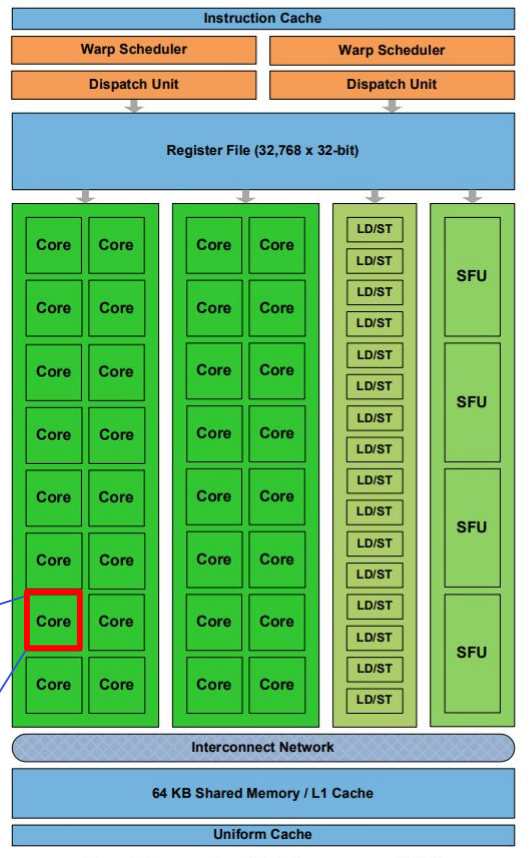

In [11]:
print("Image of an SMP:")
display(Image("./images/MCP_gpu_arch2.png", width=400))

### THREAD HIERARCHY INSIDE A GPU

In the CUDA programming model, threads are organized in a hierarchical structure that mirrors the physical architecture of the GPU.  
When a program launches a kernel (a function executed on the GPU), it defines how many threads will be used and how they are organized.

The hierarchy is as follows:
- **Thread** → the smallest execution unit. Each thread runs the same kernel code but operates on different data. A maximum of **1024 threads per block** is imposed by CUDA. Each thread is executed by a single CUDA core.
- **Block** → a group of threads that can cooperate via shared memory and synchronization. Each block is scheduled on one Streaming Multiprocessor (SM). As soon as a block finishes, a new one is assigned to that SMP. The execution order of blocks is not guaranteed. Blocks can execute in *any order* and may run concurrently. A single block with thousands of threads will not be efficient on devices with multiple SMPs, since it would occupy only one SMP while others remain idle.
- **Grid** → a collection of thread blocks that together execute a single kernel. The entire grid is distributed across all SMs in the GPU.

Each block is 'monolithic', which means in a SMP CUDA will compute one block and switch to the next only when that block is finished. But SMPs are not synchronized, so some SMPs could compute faster some blocks than other SMPs. For example in the image below (in the device example on the bottom), SM2 could switch to block 5 before SM! has finished block 1 (it will then switch to block 4).

#### WARP
**A warp is a hardware execution unit consisting of 32 threads within a block that execute the same instruction at the same time on different data elements.** 

When a kernel is launched:
- Threads are grouped into warps of 32.
- Each SM schedules and manages multiple warps concurrently.
- If threads in a warp take different execution paths (e.g., due to an `if` condition), the warp executes both paths sequentially — this is known as warp divergence, and it reduces performance.

The warp is therefore the basic scheduling unit on the GPU. The SM switches between active warps to hide memory latency — while one warp waits for data, another can execute instructions.

Modern architectures (e.g., NVIDIA Maxwell) include multiple warp schedulers per SMP, allowing several warps to execute concurrently.
For example, one SMP may host four warp schedulers, each responsible for selecting an eligible warp to execute next.
A warp is eligible when:
* Its next instruction has been fetched.
* All operands are ready.
* The required resources (e.g., FP32 ALUs) are available.

This scheduling mechanism hides memory latency and keeps the GPU cores highly utilized.  
However, different warps are not synchronized with one another and can execute independently.


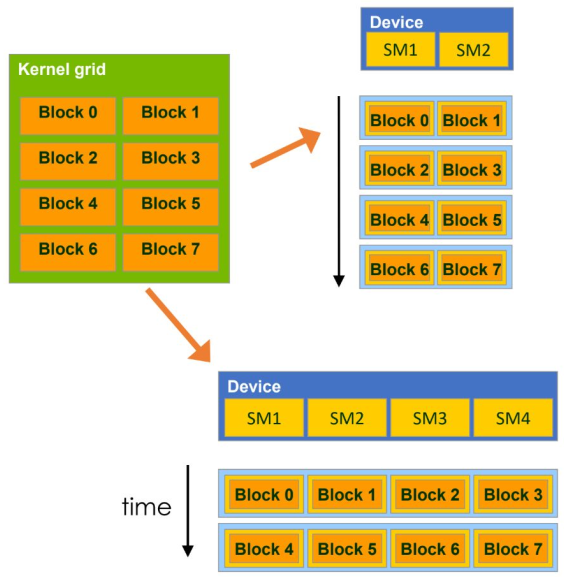

In [4]:
display(Image("./images/MCP_blocks_SMP.png", width=350))

### EXAMPLE OF THREAD DIVISION
Suppose you launch a kernel with:
- Grid = 4 blocks
- Block = 256 threads

This means the total number of threads is:
$$
4 \text{ blocks} \times 256 \text{ threads per block} = 1024 \text{ threads total.}
$$

Now, since each warp contains 32 threads: $ 256 \text{ threads per block} \div 32 = 8 \text{ warps per block.} $  
So the GPU will manage: $ 4 \text{ blocks} \times 8 \text{ warps per block} = 32 \text{ warps total.} $

Each Streaming Multiprocessor (SM) can hold several blocks at once (depending on hardware resources), meaning that multiple warps from different blocks can be active simultaneously.  

For example, if the GPU has 8 SMs, it could distribute the work like this:
- Each SM runs 0 to 2 blocks, depending on scheduling.
- Within each SM, there are multiple active warp that the hardware switches between to keep all CUDA cores busy.

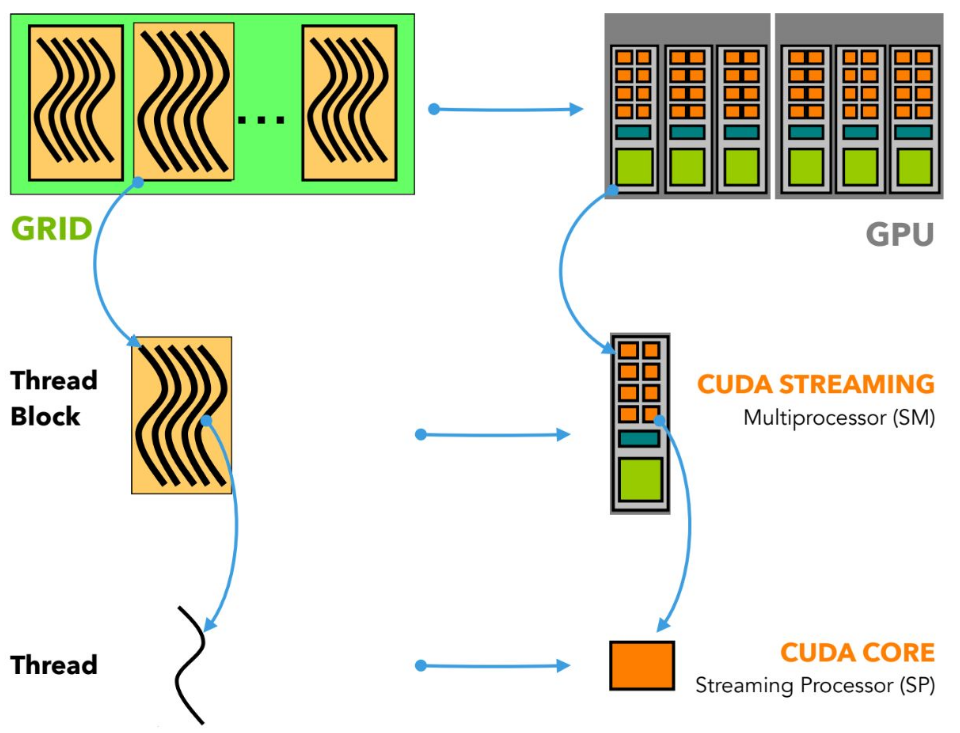

In [4]:
display(Image("./images/MCP_grid_block_thread.png", width=600))

### MEMORY AND DATA TRANSFER CONSIDERATIONS

Because GPUs are designed for massively data-parallel computations, their performance strongly depends on how efficiently data can be transferred between memory and the CUDA cores. A GPU can only process data that is accessible to its cores, meaning that memory bandwidth — the rate at which data can move between memory and the processors — becomes a crucial limiting factor. In other words:
> A GPU can compute no faster than it can feed data to its cores.

GPUs achieve high efficiency when the computation fully exploits the available memory bandwidth, maintaining high throughput. However, if data transfers are slow or unoptimized, the many cores of the GPU may remain idle, waiting for data to arrive.

#### EXAMPLE: NVIDIA V100 GPU

Let’s look at an example to understand how memory bandwidth limits performance. GPU V100 specifications:
- Memory: 16 GB HBM2  
- Memory bandwidth: **900 GB/s** (data transfer rate between the GPU’s on-board memory (HBM2) and its internal cuda cores). 
- CUDA cores: **5120**  
- Clock frequency: **1.53 GHz**

Let’s make some assumptions:
- We ignore cache effects (L1/L2 and registers).
- Each CUDA core performs one simple floating-point operation (4 Bytes) per data element.

Step 1: Maximum floating-point operations per second (before bandwidth saturation)  
Since every operation requires 4 Bytes, the maximum possible rate before exceeding the memory bandwidth is:

$$
\text{FLOPS} = \frac{900\ \text{GB/s}}{4\ \text{B}} = 225\ \text{GFLOPS}
$$

This means that if every operation requires data directly from memory, the GPU cannot exceed 225 GFLOPS, regardless of how many CUDA cores it has — the memory becomes the bottleneck.

Step 2: Data transfer per GPU clock cycle
$$
\frac{900\ \text{GB/s}}{1.53\ \text{GHz}} = 588\ \text{Bytes per cycle (for the entire GPU)}
$$

Step 3: Data transfer per CUDA core

$$
\frac{588\ \text{Bytes per cycle}}{5120\ \text{cores}} \approx 0.11\ \text{Bytes per cycle per core}
$$

That means each CUDA core can process about 1 Byte every 9 clock cycles if all data must come directly from memory.  
This simple calculation shows why **GPUs rely heavily on fast local memory (registers, shared memory, and caches) to keep cores busy and hide memory latency**.

#### CPU–GPU CONNECTION

In most systems, GPUs work together with CPUs. **Data must be exchanged between CPU and GPU memory spaces through dedicated communication buses**, which can themselves become performance bottlenecks.

- PCI Express (PCIe) bus:
  - PCIe 3.0 → up to 8 GT/s (~16 GB/s)
  - PCIe 4.0 → up to 16 GT/s (~32 GB/s)
  - PCIe 5.0 → up to 32 GT/s (~64 GB/s)

These buses enable faster CPU–GPU communication, reducing transfer overhead for large datasets. However data movement between the CPU and GPU is much slower than internal GPU memory operations, so minimizing transfers between host and device is essential for optimal performance.

In summary, memory bandwidth and data transfer latency are among the key factors determining GPU performance. Efficient GPU programming must therefore focus not only on parallel computation but also on optimizing data locality, minimizing memory transfers, and maximizing cache reuse.


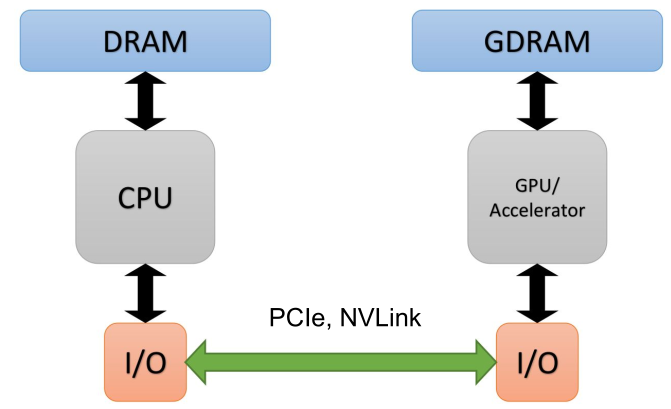

In [12]:
display(Image("./images/MCP_pci.png", width=400))

### THREAD INDEXING

Grids and blocks are structured in geometrical hierarchies to represent parallel computations.
- A grid is usually a 3D array of blocks.  
- Each block is usually a 3D array of threads.  
- These dimensions can be 1D, 2D, or 3D — it’s up to the programmer to choose what best fits the data (e.g., arrays, matrices, tensors).

CUDA provides built-in variables to manage and identify threads and blocks:

| Variable | Type | Description |
|-----------|------|-------------|
| `gridDim` | `dim3` | Dimensions of the grid |
| `blockIdx` | `uint3` | Index of the current block within the grid |
| `blockDim` | `dim3` | Dimensions of the current block |
| `threadIdx` | `uint3` | Index of the current thread within the block |

These variables allow each thread to compute a unique global index, which can then be used to access different data elements.  


```c
// EXAMPLE OF STRUCTURE:
dim3 blockSize(4, 4);    // 4x4 threads in a block
dim3 gridSize(3, 2, 2);  // 3x2x2 blocks in a grid
my_kernel<<<gridSize, blockSize>>>(input_data, output_data);

// EXAMPLE OF INDEXING:
int id_x = blockIdx.x * blockDim.x + threadIdx.x;
int id_y = blockIdx.y * blockDim.y + threadIdx.y;
int id_z = blockIdx.z * blockDim.z + threadIdx.z;
```

Example of safe access:
```c
if (idx < N) {
    data[idx] = some_computation();
}

```


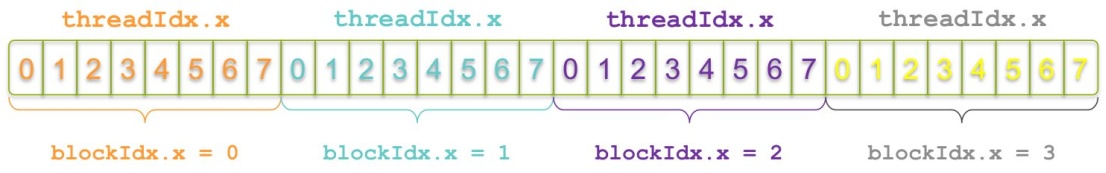

In [6]:
display(Image("./images/MCP_thread_indexing.png", width=800))

### POSSIBLE PROBLEMS IN INDEXING

What if the vector size is not neatly divisible by blocks and threads?

To solve this, **we simply ensure there are enough threads to cover the entire data range, even if some threads do not actually perform computations**.  
We typically use the **ceiling function** to determine the number of required blocks:

$$
N_{\text{blocks}} = \lceil \frac{N}{\text{THREADS\_PER\_BLOCK}} \rceil
$$

Example:
```c
N = 1021     // data size
THREADS_PER_BLOCK = 128
N / THREADS_PER_BLOCK = 7.976 → 8 blocks
```

Then, inside the kernel, we verify that each thread operates only on valid data. A kernel attempting to access a non-existent data location is going to fail and crash the application.

```c
int idx = blockIdx.x * blockDim.x + threadIdx.x;
if (idx < N) {
    output[idx] = some_operation(input[idx]);
}

```

---

---

---

---

# 02 - CUDA CODING

### CUDA FUNCTIONS

In CUDA, a function that runs on a GPU is called a kernel. When a kernel is launched, it can be executed by thousands of threads across the GPU’s Streaming Multiprocessors (SMs). Each thread typically operates independently on a different data element. Programmers can control the number of threads to run, defining the degree of parallelism.

The `__global__` specifier indicates that this function is a kernel, meaning it is launched by the host (CPU) but executed on the device (GPU).   
**When invoked from the host, kernels must always return void.**

> A kernel function is declared using the `__global__` keyword

```c
__global__ void a_kernel(void) {
    // Code executed on the GPU
}
```

By default, all functions in a CUDA program are host functions if they lack CUDA-specific keywords. Host functions are ordinary C/C++ functions and can return values like int or float. 

Device functions, declared with `__device__`, are executed on the GPU and can only be called from an active kernel, but they can also return values. It is also possible to declare a function with both `__host__` and `__device__`, which generates two versions of the same function — one for CPU execution and one for GPU execution — at compile time.

| & | executed on the | only callable from the |
|-------------------------------|----------------|-----------------------|
| `__device__ float DeviceFunc()` | device | device |
| `__global__ void KernelFunc()` | device | host (to launch) |
| `__host__ float HostFunc()` | host | host |

A kernel is launched using the triple-angle bracket syntax:
```c
a_kernel<<<n_blocks, n_threads_per_block>>>();
```
Here, the parameters inside `<<< >>>` specify the execution configuration: the number of blocks in the grid and the number of threads per block. The parameters inside the standard parentheses `()` are the kernel input data, if any.  
The total number of times the kernel code is executed is:
$$
\text{total threads} = n\_blocks \times n\_threads\_per\_block
$$

### SYNCHRONIZATION
In CUDA, **kernel launches are asynchronous**, meaning that when you launch a kernel from the host (CPU), control returns immediately to the CPU without waiting for the GPU to finish executing the kernel. This allows the CPU to continue executing other code while the GPU is working, which can improve overall performance.

However, there are situations where the host needs to wait until the GPU has completed its work, for example before reading results from GPU memory back to the CPU, or before performing computations that depend on the results of a previous kernel.

The function `cudaDeviceSynchronize();` forces the host to wait until all previously launched kernels on the device have finished execution. Essentially, it synchronizes the CPU with the GPU, ensuring that all GPU work is complete before the host continues.

```c
// EXAMPLE:
int main(int argc, char **argv){
// CPU can do something here
...
// Asynchronous kernel launch (non-blocking)
my_kernel<<<N_BLOCKS,N_THREADS_PER_BLOCK>>>();
// CPU can continue to do something here
...
// When necessary to force the synchronization
cudaDeviceSynchronize();
// CPU execution is blocked until all threads are done
...
}
```

### NVCC
To compile a CUDa/C++ program, you need the `nvcc` compiler, similar to the known `gcc`. The nvcc compiler automatically separates host and device code: device functions are processed by the NVIDIA compiler, while host functions are handled by the system C/C++ compiler (e.g., gcc).
```bash
nvcc hello_world.cu -o hello_world.out
```
Commonly used options:
- `-o <file>`: Specifies the output file name.
- `-arch=sm_XY`: Specifies the GPU architecture (e.g., sm_86 for RTX 30xx, sm_89 for RTX 40xx).
- `--use_fast_math`: Enables faster (but slightly less precise) math operations.
- `--run`: Compiles and immediately runs the program (shortcut).

### MEMORY MANAGEMENT PROCEDURE

In CUDA, while kernel launches are asynchronous, data transfers between Host (CPU) and Device (GPU) are synchronous by default, so the CPU waits until the transfer is complete.

Kernels operate on device memory, so any pointer used inside a kernel must reference GPU memory. To use data on the GPU, you generally follow these steps:
1. Host memory allocation and declaration: allocate and initialize input and output data on the CPU.
2. Device memory allocation: allocate memory on the GPU to hold input and output data.
3. Host → Device data transfer: copy input data from CPU memory to GPU memory so the kernel can access it.
4. Device → Host data transfer: after kernel execution, copy the results from GPU memory back to CPU memory for further use.
5. Free memory: release both CPU and GPU memory to avoid memory leaks.

### STATIC VS DYNAMIC MEMORY

On the GPU, you can use both static and dynamic memory, but there are important differences compared to CPU memory. You can declare variables inside a kernel or device function just like on the CPU:
```c
__global__ void myKernel() {
    int a = 5;          // automatic variable, stored in a thread's registers
    float b[10];        // small local array, stored in registers or local memory
}
```

But watch out: **these variables are private to each thread**. They are stored in registers (fastest) or local memory if registers run out. Size must be known at compile time. Cannot be shared between threads across blocks (unless using `__shared__` memory).

To allocate memory that can be accessed like arrays or large buffers, you use `cudaMalloc()`, that allocates memory in device global memory (VRAM):
```c
int *d_arr;
cudaMalloc(&d_arr, N * sizeof(int));
```

Memory persists across kernel launches until explicitly freed with cudaFree().

#### SHARED MEMORY

Inside a kernel, you can also declare shared memory, which is fast memory shared among threads of a block. Threads in the same block can read/write to it. Lifetime is limited to the block execution.
```c
__shared__ float s_data[256];
```

> Conclusion:
For small, temporary variables you can use static allocation. For large arrays or data that must persist across threads/kernels, you need dynamic allocation with cudaMalloc.

### CUDA APIs

*API* stands for *Application Programming Interface*. It is a set of functions, protocols, and tools that allows different software components to communicate with each other. In the context of CUDA, the CUDA API provides a collection of functions that let you control the GPU, manage memory, and launch kernels from your CPU code.

CUDA provides functions similar to standard C memory operations:
- **`cudaMalloc(void **device_pointer, size)`** → allocates memory on the GPU device
- **`cudaFree(void *device_pointer)`** → releases previously allocated memory in GPU
- **`cudaMemcpy(*dest, *src, size, kind)`** → copies memory between host and device (from src to dest). The kind parameter specifies the direction:
    - `cudaMemcpyHostToDevice`: copy from CPU memory to GPU memory
    - `cudaMemcpyDeviceToHost`: copy from GPU memory to CPU memory
    - `cudaMemcpyDeviceToDevice`: copy between GPU memory regions
    - `cudaMemcpyHostToHost	Copy`: between CPU memory regions

```c
// EXAMPLE:

// 1. Allocate host memory
float *h_data = (float*) malloc(N * sizeof(float));

// 2. Allocate device memory
float *d_data;
cudaMalloc(&d_data, N * sizeof(float));

// 3. Copy data from Host to Device
cudaMemcpy(d_data, h_data, N * sizeof(float), cudaMemcpyHostToDevice);

// 4. Launch kernel
myKernel<<<numBlocks, threadsPerBlock>>>(d_data);

// 5. Copy results back from Device to Host
cudaMemcpy(h_data, d_data, N * sizeof(float), cudaMemcpyDeviceToHost);

// 6. Free memory
cudaFree(d_data);
free(h_data);
```